In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import torch
print("pytorch ver . ",torch.__version__)
print("Is CUDA available?",torch.cuda.is_available())
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader
import torch.utils.data as Data
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import xarray as xr
import os
os.environ['R_HOME'] = '/home/luhung3080/miniconda3/envs/chou/lib/R'
from rpy2.robjects import r, numpy2ri
numpy2ri.activate()
from rpy2.robjects.packages import importr
sinkr = importr('sinkr')
import Nio
print ("pynio ver . ",Nio.__version__)

/home/luhung3080/miniconda3/envs/chou/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


pytorch ver .  1.11.0+cu113
Is CUDA available? True
pynio ver .  1.5.5


In [2]:
data=pd.read_csv('v100_hr_20200101-0930_cut_utf8.csv')

/home/luhung3080/miniconda3/envs/chou/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3524: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


# Y = b0 + b1X1 (96hr)

In [103]:
###
#cal_PMf  
###
u=np.zeros([244,6816])
for i in range (0,244):
    a=np.array(data['cal_PMf'][6816*i:6816*i+6816])
    for j in range(0,6816):
        if a[j]=='\\N' :
            a[j]=np.nan
    u[i]=a.T
###
#obs_PMf
###
v=np.zeros([244,6816])
for i in range (0,244):
    a=np.array(data['obs_PMf'][6816*i:6816*i+6816])
    for j in range(0,6816):
        if a[j]=='\\N' :
            a[j]=np.nan
    v[i]=a.T

print(np.shape(u))
print(np.shape(v))

(244, 6816)
(244, 6816)


In [104]:
XRestruct=sinkr.dineof(u)
YRestruct=sinkr.dineof(v)

[1] "1 EOF ; RMS = 9.93506801"
[1] "1 EOF ; RMS = 9.92613522"
[1] "1 EOF ; RMS = 9.92636403"
[1] "2 EOF ; RMS = 9.02756575"
[1] "2 EOF ; RMS = 9.02624323"
[1] "2 EOF ; RMS = 9.02611752"
[1] "2 EOF ; RMS = 9.02607211"
[1] "2 EOF ; RMS = 9.02605448"
[1] "2 EOF ; RMS = 9.02604729"
[1] "3 EOF ; RMS = 8.70249363"
[1] "3 EOF ; RMS = 8.70435635"
[1] "4 EOF ; RMS = 8.46576495"
[1] "4 EOF ; RMS = 8.47310206"
[1] "5 EOF ; RMS = 8.30686772"
[1] "5 EOF ; RMS = 8.32268705"
[1] "6 EOF ; RMS = 8.23892984"
[1] "6 EOF ; RMS = 8.25361783"
[1] "7 EOF ; RMS = 8.15532496"
[1] "7 EOF ; RMS = 8.16791977"
[1] "8 EOF ; RMS = 8.09537777"
[1] "8 EOF ; RMS = 8.11839344"
[1] "9 EOF ; RMS = 8.11322832"
[1] "9 EOF ; RMS = 8.15047305"
[1] "10 EOF ; RMS = 8.13616664"
[1] "10 EOF ; RMS = 8.16005763"
[1] "11 EOF ; RMS = 8.08949966"
[1] "11 EOF ; RMS = 8.09875024"
[1] "12 EOF ; RMS = 8.04003736"
[1] "12 EOF ; RMS = 8.05846835"
[1] "13 EOF ; RMS = 8.02165135"
[1] "13 EOF ; RMS = 8.04179708"
[1] "14 EOF ; RMS = 7.9883091"


In [105]:
XRestruct_Fun=np.array(XRestruct[0])
YRestruct_Fun=np.array(YRestruct[0])
print(type(XRestruct_Fun))
print(type(YRestruct_Fun))
print(np.shape(XRestruct_Fun))
print(np.shape(YRestruct_Fun))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(244, 6816)
(244, 6816)


In [106]:
Xhat=XRestruct_Fun
Yhat=YRestruct_Fun
Xhat_train = np.zeros([244,6816])
Yhat_train = np.zeros([244,6816])
for i in range (0,244):
    for j in range (0,6816):
        Xhat_train[i][j] = Xhat[i][j]
        Yhat_train[i][j] = Yhat[i][j]

Xhat_test = np.zeros([30,6816])
Yhat_test = np.zeros([30,6816])
#data_cal
for i in range (244,274):
    a=np.array(data['cal_PMf'][6816*i:6816*i+6816])
    for j in range(0,6816):
        if a[j]=='\\N' :
            a[j]=np.nan
    Xhat_test[i-244]=a
#data_obs
for i in range (244,274):
    a=np.array(data['obs_PMf'][6816*i:6816*i+6816])
    for j in range(0,6816):
        if a[j]=='\\N' :
            a[j]=np.nan
    Yhat_test[i-244]=a
print('Xhat_train')
#print(Xhat_train)
print(np.shape(Xhat_train))
print('Yhat_train')
#print(Yhat_train)
print(np.shape(Yhat_train))
print('Xhat_test')
#print(Xhat_test)
print(np.shape(Xhat_test))
print('Yhat_test')
#print(Yhat_test)
print(np.shape(Yhat_test))

Xhat_train
(244, 6816)
Yhat_train
(244, 6816)
Xhat_test
(30, 6816)
Yhat_test
(30, 6816)


## GD

In [107]:
x = Xhat_train
y = Yhat_train
xt = Xhat_test
yt = Yhat_test

In [108]:
def model (x,b0,b1):
    # y = b0 +  torch.matmul(x,b1)
    y = b0 + b1*x
    return y

In [109]:
features = torch.from_numpy(x)
targets = torch.from_numpy(y)
x_test = torch.from_numpy(xt)
y_test = torch.from_numpy(yt)

# beta0 = torch.randn(6816 , requires_grad = True)
# # beta1 = torch.randn([6816 , 6816], requires_grad = True)
# beta1 = torch.randn(6816, requires_grad = True)

beta0 = torch.ones(6816 , requires_grad = True)
beta1 = torch.ones(6816, requires_grad = True)

rate = 1e-2
optimizer = optim.Adam([beta0 , beta1], lr=rate)

epo = 2001
loss = nn.L1Loss()
train_error = np.zeros(epo)
test_error = np.zeros(epo)


for epoch in range (epo):
    yhats_train = model(features.float() , beta0 , beta1)
    train_loss = loss(targets.float() , yhats_train)
    train_error[epoch] = train_loss

    optimizer.zero_grad()
    train_loss.backward() 
    optimizer.step()    

    yhats_test = model(x_test.float(), beta0, beta1) 
#     for i in range (30):
#         for j in range (6816):
#             if y_test[i][j] == 0:
#                 yhats_test[i][j] = 0
    r = abs(yhats_test - y_test)
    test_loss = torch.nanmean(r)
    # test_loss = loss(y_test , yhats_test)
    test_error[epoch] = test_loss

    if epoch <= 10 or epoch % 10 == 0:
        print(f"Epoch {epoch}, Training loss {train_loss.item():.4f},"
                    f" Testing loss {test_loss.item():.4f}")
        # print('\tBeta_0 : ' , beta0)
        # print('\tBeta_1 : ' , beta1)
    else :
        if epoch >= epo-10 :
            print(f"Epoch {epoch}, Training loss {train_loss.item():.4f},"
                        f" Testing loss {test_loss.item():.4f}")
            # print('\tBeta_0 : ' , beta0)
            # print('\tBeta_1 : ' , beta1)

Epoch 0, Training loss 8.1924, Testing loss 7.4484
Epoch 1, Training loss 8.1388, Testing loss 7.4147
Epoch 2, Training loss 8.0869, Testing loss 7.3829
Epoch 3, Training loss 8.0368, Testing loss 7.3529
Epoch 4, Training loss 7.9885, Testing loss 7.3247
Epoch 5, Training loss 7.9419, Testing loss 7.2982
Epoch 6, Training loss 7.8972, Testing loss 7.2734
Epoch 7, Training loss 7.8543, Testing loss 7.2503
Epoch 8, Training loss 7.8132, Testing loss 7.2289
Epoch 9, Training loss 7.7738, Testing loss 7.2091
Epoch 10, Training loss 7.7362, Testing loss 7.1909
Epoch 20, Training loss 7.4477, Testing loss 7.0812
Epoch 30, Training loss 7.2874, Testing loss 7.0601
Epoch 40, Training loss 7.2029, Testing loss 7.0688
Epoch 50, Training loss 7.1549, Testing loss 7.0741
Epoch 60, Training loss 7.1227, Testing loss 7.0652
Epoch 70, Training loss 7.0965, Testing loss 7.0456
Epoch 80, Training loss 7.0732, Testing loss 7.0219
Epoch 90, Training loss 7.0516, Testing loss 6.9973
Epoch 100, Training lo

Epoch 1460, Training loss 6.5242, Testing loss 6.2317
Epoch 1470, Training loss 6.5241, Testing loss 6.2314
Epoch 1480, Training loss 6.5241, Testing loss 6.2312
Epoch 1490, Training loss 6.5240, Testing loss 6.2310
Epoch 1500, Training loss 6.5239, Testing loss 6.2307
Epoch 1510, Training loss 6.5239, Testing loss 6.2305
Epoch 1520, Training loss 6.5238, Testing loss 6.2303
Epoch 1530, Training loss 6.5238, Testing loss 6.2301
Epoch 1540, Training loss 6.5237, Testing loss 6.2299
Epoch 1550, Training loss 6.5237, Testing loss 6.2297
Epoch 1560, Training loss 6.5236, Testing loss 6.2295
Epoch 1570, Training loss 6.5236, Testing loss 6.2292
Epoch 1580, Training loss 6.5235, Testing loss 6.2291
Epoch 1590, Training loss 6.5235, Testing loss 6.2289
Epoch 1600, Training loss 6.5234, Testing loss 6.2286
Epoch 1610, Training loss 6.5234, Testing loss 6.2285
Epoch 1620, Training loss 6.5234, Testing loss 6.2284
Epoch 1630, Training loss 6.5233, Testing loss 6.2283
Epoch 1640, Training loss 6.

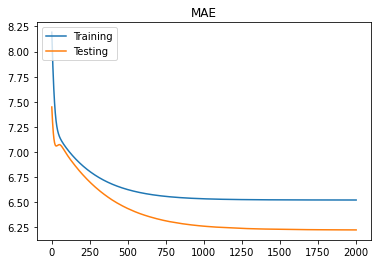

In [110]:
fig1 = plt.figure(1)
x=np.linspace(1,epo,epo)
plt.plot(x,train_error, label = 'Training')
plt.plot(x,test_error, label ='Testing')
plt.legend(loc = 2)
plt.title('MAE')

plt.show()

In [111]:
print(np.min(test_error))

6.224822758638766


# Y = b0 + b1X12 (120hr)

In [3]:
old_x=np.zeros([274,6816])
old_y=np.zeros([274,6816])
#data_cal
for i in range (0,274):
    a=np.array(data['cal_PMf'][6816*i:6816*i+6816])
    for j in range(0,6816):
        if a[j]=='\\N' :
            a[j]=np.nan
    old_x[i]=a
#data_obs
for i in range (0,274):
    a=np.array(data['obs_PMf'][6816*i:6816*i+6816])
    for j in range(0,6816):
        if a[j]=='\\N' :
            a[j]=np.nan
    old_y[i]=a
print(np.shape(old_x))
print(np.shape(old_y))

old_x1=np.zeros([244,6816])
old_y1=np.zeros([244,6816])
for i in range (0,244):
    for j in range (0,6816):
        old_x1[i][j]=old_x[i][j]
        old_y1[i][j]=old_y[i][j]
before1=abs(old_x1-old_y1)
before_error1=np.nanmean(before1)
print("January to August (training data set) before_error (MADE) : %f" %before_error1)

old_x2=np.zeros([30,6816])
old_y2=np.zeros([30,6816])
for i in range (0,30):
    for j in range (0,6816):
        old_x2[i][j]=old_x[i+244][j]
        old_y2[i][j]=old_y[i+244][j]
before2=abs(old_x2-old_y2)
before_error2=np.nanmean(before2)
print("September (testing data set) before_error (MADE) : %f" %before_error2)

(274, 6816)
(274, 6816)
January to August (training data set) before_error (MADE) : 8.247546
September (testing data set) before_error (MADE) : 7.586688


In [4]:
x1=np.zeros([243,1704])
x2=np.zeros([243,6816])

#x1 (0th~1703th column as x)
for i in range (0,243):
    for j in range (0,71):
        a=np.array(data['obs_PMf'][6816*i+96*j:6816*i+96*j+24])
        for k in range (0,24):
            if a[k]=='\\N' :
                a[k]=np.nan
        for k in range (0,24):
            x1[i][j*24+k]=a[k]

#x2 (1704th~8519th column as x)
for i in range (1,244):
    b=np.array(data['cal_PMf'][6816*i:6816*i+6816])
    for j in range(0,6816):
        if b[j]=='\\N' :
            b[j]=np.nan
    for j in range(0,6816):
        x2[i-1][j]=b[j]
        
print(np.shape(x1))
print(np.shape(x2))

(243, 1704)
(243, 6816)


In [5]:
x1Restruct=sinkr.dineof(x1)
x2Restruct=sinkr.dineof(x2)

[1] "1 EOF ; RMS = 7.13544337"
[1] "1 EOF ; RMS = 7.09625196"
[1] "1 EOF ; RMS = 7.09722521"
[1] "2 EOF ; RMS = 6.27948371"
[1] "2 EOF ; RMS = 6.27709497"
[1] "2 EOF ; RMS = 6.27696686"
[1] "2 EOF ; RMS = 6.2769576"
[1] "3 EOF ; RMS = 5.9109914"
[1] "3 EOF ; RMS = 5.92209935"
[1] "4 EOF ; RMS = 5.57778421"
[1] "4 EOF ; RMS = 5.57372761"
[1] "4 EOF ; RMS = 5.57350379"
[1] "4 EOF ; RMS = 5.57347823"
[1] "4 EOF ; RMS = 5.5734743"
[1] "5 EOF ; RMS = 5.31674553"
[1] "5 EOF ; RMS = 5.31855832"
[1] "6 EOF ; RMS = 5.16658233"
[1] "6 EOF ; RMS = 5.16906346"
[1] "7 EOF ; RMS = 5.08883393"
[1] "7 EOF ; RMS = 5.09603281"
[1] "8 EOF ; RMS = 5.06102197"
[1] "8 EOF ; RMS = 5.06821764"
[1] "9 EOF ; RMS = 4.97645539"
[1] "9 EOF ; RMS = 4.97205797"
[1] "9 EOF ; RMS = 4.96990287"
[1] "9 EOF ; RMS = 4.96868843"
[1] "9 EOF ; RMS = 4.96801768"
[1] "9 EOF ; RMS = 4.96764745"
[1] "9 EOF ; RMS = 4.96744109"
[1] "9 EOF ; RMS = 4.96732463"
[1] "9 EOF ; RMS = 4.96725816"
[1] "9 EOF ; RMS = 4.96721989"
[1] "9 EOF 

In [6]:
x1Restruct_Fun=np.array(x1Restruct[0])
x2Restruct_Fun=np.array(x2Restruct[0])
print(np.shape(x1Restruct_Fun))
print(np.shape(x2Restruct_Fun))

(243, 1704)
(243, 6816)


In [7]:
YRestruct_Fun=np.zeros([239,6816])
for i in range (0,239):
    for j in range (0,1704):
        YRestruct_Fun[i][j]=x1Restruct_Fun[i+1][j]
    for j in range (1704,3408):
        YRestruct_Fun[i][j]=x1Restruct_Fun[i+2][j-1704]
    for j in range (3408,5112):
        YRestruct_Fun[i][j]=x1Restruct_Fun[i+3][j-3408]
    for j in range (5112,6816):
        YRestruct_Fun[i][j]=x1Restruct_Fun[i+4][j-5112]
print(np.shape(YRestruct_Fun))

(239, 6816)


In [8]:
XRestruct_Fun=np.zeros([239,8520])
for i in range (0,239):
    for j in range (0,1704):
        XRestruct_Fun[i][j]=x1Restruct_Fun[i][j]
    for j in range (1704,8520):
        XRestruct_Fun[i][j]=x2Restruct_Fun[i][j-1704]
print(np.shape(XRestruct_Fun))

(239, 8520)


In [9]:
Xhat=XRestruct_Fun
Yhat=YRestruct_Fun
Xhat_train = np.zeros([239,8520])
Yhat_train = np.zeros([239,6816])
for i in range (0,239):
    for j in range (0,8520):
        Xhat_train[i][j] = Xhat[i][j]
    for j in range (0,6816):    
        Yhat_train[i][j] = Yhat[i][j]

Xhat_test = np.zeros([30,8520])
Yhat_test = np.zeros([30,6816])
x=np.zeros([273,8520])
y=np.zeros([273,6816])
#x1 (0th~1703th column as x)
for i in range (0,273):
    for j in range (0,71):
        a=np.array(data['obs_PMf'][6816*i+96*j:6816*i+96*j+24])
        for k in range (0,24):
            if a[k]=='\\N' :
                a[k]=np.nan
        for k in range (0,24):
            x[i][j*24+k]=a[k]

#x2 (1704th~8519th column as x)
for i in range (1,274):
    b=np.array(data['cal_PMf'][6816*i:6816*i+6816])
    for j in range(0,6816):
        if b[j]=='\\N' :
            b[j]=np.nan
    for j in range(0,6816):
        x[i-1][j+1704]=b[j]

#data_obs
for i in range (1,274):
    a=np.array(data['obs_PMf'][6816*i:6816*i+6816])
    for j in range(0,6816):
        if a[j]=='\\N' :
            a[j]=np.nan
    y[i-1]=a
xRestruct=sinkr.dineof(x)
yRestruct=sinkr.dineof(y)
xRestruct_Fun=np.array(xRestruct[0])
yRestruct_Fun=np.array(yRestruct[0])
    
for i in range (243,273):
    for j in range (0,8520):
        Xhat_test[i-243][j]=xRestruct_Fun[i][j]
    for j in range(0,6816):
        Yhat_test[i-243][j]=yRestruct_Fun[i][j]

[1] "1 EOF ; RMS = 9.5505826"
[1] "1 EOF ; RMS = 9.54045039"
[1] "1 EOF ; RMS = 9.5405316"
[1] "2 EOF ; RMS = 8.79432057"
[1] "2 EOF ; RMS = 8.79431739"
[1] "3 EOF ; RMS = 8.56430541"
[1] "3 EOF ; RMS = 8.56714458"
[1] "4 EOF ; RMS = 8.35045958"
[1] "4 EOF ; RMS = 8.35452706"
[1] "5 EOF ; RMS = 8.17712072"
[1] "5 EOF ; RMS = 8.17761129"
[1] "6 EOF ; RMS = 8.03637738"
[1] "6 EOF ; RMS = 8.04082152"
[1] "7 EOF ; RMS = 7.93151963"
[1] "7 EOF ; RMS = 7.93463602"
[1] "8 EOF ; RMS = 7.85853584"
[1] "8 EOF ; RMS = 7.87084951"
[1] "9 EOF ; RMS = 7.75872786"
[1] "9 EOF ; RMS = 7.7596391"
[1] "10 EOF ; RMS = 7.7097736"
[1] "10 EOF ; RMS = 7.72357843"
[1] "11 EOF ; RMS = 7.68024963"
[1] "11 EOF ; RMS = 7.69140625"
[1] "12 EOF ; RMS = 7.66417839"
[1] "12 EOF ; RMS = 7.67838404"
[1] "13 EOF ; RMS = 7.61631043"
[1] "13 EOF ; RMS = 7.62514077"
[1] "14 EOF ; RMS = 7.61311857"
[1] "14 EOF ; RMS = 7.63079602"
[1] "15 EOF ; RMS = 7.60906558"
[1] "15 EOF ; RMS = 7.62602666"
[1] "16 EOF ; RMS = 7.61326186"

In [10]:
old_x=np.zeros([30,6816])
old_y=np.zeros([30,6816])
for i in range (0,30):
    for j in range (0,6816):
        old_x[i][j]=x[i+243][j+1704]
        old_y[i][j]=y[i+243][j]
before=abs(old_x-old_y)
before_error=np.nanmean(before)
print("September (testing data set) before_error (MADE) : %f" %before_error)

September (testing data set) before_error (MADE) : 7.586688


In [97]:
print('Xhat_train')
#print(Xhat_train)
print(np.shape(Xhat_train))
print('Yhat_train')
#print(Yhat_train)
print(np.shape(Yhat_train))
print('Xhat_test')
#print(Xhat_test)
print(np.shape(Xhat_test))
print('Yhat_test')
#print(Yhat_test)
print(np.shape(Yhat_test))

Xhat_train
(239, 8520)
Yhat_train
(239, 6816)
Xhat_test
(30, 8520)
Yhat_test
(30, 6816)


## GD

In [98]:
x = Xhat_train
y = Yhat_train
xt = Xhat_test
yt = Yhat_test

In [99]:
def model (x,b0,b1):
    # y = b0 +  torch.matmul(x,b1)
    # y = torch.add(b0 +  torch.matmul(x,b1))
    y = b0 +  torch.mm(x , b1)
#     y_8520 = b0 + b1*x
#     y = y_8520[ : , 1704: ]

    # y = torch.zeros(len(y_8520),6816)
    # for i in range (0,len(y_8520)):
    #     for j in range (0,6816):
    #         y[i][j] = y_8520[i][j+1704]
    return y

In [100]:
features = torch.from_numpy(x)
targets = torch.from_numpy(y)
x_test = torch.from_numpy(xt)
y_test = torch.from_numpy(yt)

# beta0 = torch.randn(6816 , requires_grad = True)
# beta1 = torch.randn([8520 , 6816], requires_grad = True)

beta0 = torch.ones(6816 , requires_grad = True)
beta1 = torch.ones([8520,6816], requires_grad = True)

rate = 1e-3
# optimizer = optim.LBFGS([beta0 , beta1] , lr = rate)
optimizer = optim.Adam([beta0 , beta1], lr=rate)
# optimizer = optim.SGD([beta0 , beta1], lr=rate)

epo = 2001
loss = nn.L1Loss()
train_error = np.zeros(epo)
test_error = np.zeros(epo)


for epoch in range (epo):
    yhats_train = model(features.float() , beta0 , beta1)
    train_loss = loss(targets.float() , yhats_train)
    train_error[epoch] = train_loss

    optimizer.zero_grad()
    train_loss.backward() 
    optimizer.step()    

    yhats_test = model(x_test.float(), beta0, beta1) 
#     for i in range (25):
#         for j in range (6816):
#             if y_test[i][j] == 0:
#                 yhats_test[i][j] = 0
    r = torch.abs(yhats_test - y_test)
    test_loss = torch.nanmean(r)
    # test_loss = loss(y_test , yhats_test)
    test_error[epoch] = test_loss

    if epoch <= 10 or epoch % 10 == 0:
        print(f"Epoch {epoch}, Training loss {train_loss.item():.4f},"
                    f" Testing loss {test_loss.item():.4f}")
        # print('\tBeta_0 : ' , beta0)
        # print('\tBeta_1 : ' , beta1)
    else :
        if epoch >= epo-10 :
            print(f"Epoch {epoch}, Training loss {train_loss.item():.4f},"
                        f" Testing loss {test_loss.item():.4f}")
            # print('\tBeta_0 : ' , beta0)
            # print('\tBeta_1 : ' , beta1)

Epoch 0, Training loss 128670.6719, Testing loss 122753.0257
Epoch 1, Training loss 128541.9922, Testing loss 122630.1358
Epoch 2, Training loss 128413.3125, Testing loss 122507.2494
Epoch 3, Training loss 128284.6250, Testing loss 122384.3478
Epoch 4, Training loss 128155.9219, Testing loss 122261.4567
Epoch 5, Training loss 128027.2344, Testing loss 122138.5731
Epoch 6, Training loss 127898.5625, Testing loss 122015.6970
Epoch 7, Training loss 127769.9062, Testing loss 121892.7921
Epoch 8, Training loss 127641.2031, Testing loss 121769.9038
Epoch 9, Training loss 127512.5234, Testing loss 121647.0173
Epoch 10, Training loss 127383.8125, Testing loss 121524.1272
Epoch 20, Training loss 126097.0000, Testing loss 120295.2564
Epoch 30, Training loss 124810.1328, Testing loss 119066.3270
Epoch 40, Training loss 123523.3125, Testing loss 117837.4366
Epoch 50, Training loss 122236.4609, Testing loss 116608.5334
Epoch 60, Training loss 120949.6562, Testing loss 115379.6416
Epoch 70, Training

Epoch 1280, Training loss 10.0857, Testing loss 11.6399
Epoch 1290, Training loss 10.2695, Testing loss 11.9686
Epoch 1300, Training loss 10.3951, Testing loss 11.9780
Epoch 1310, Training loss 10.5427, Testing loss 11.9272
Epoch 1320, Training loss 10.6879, Testing loss 12.1079
Epoch 1330, Training loss 10.7959, Testing loss 12.1938
Epoch 1340, Training loss 10.9407, Testing loss 12.3117
Epoch 1350, Training loss 10.9035, Testing loss 12.2909
Epoch 1360, Training loss 11.0612, Testing loss 12.2939
Epoch 1370, Training loss 11.0371, Testing loss 12.3946
Epoch 1380, Training loss 11.2386, Testing loss 12.5346
Epoch 1390, Training loss 11.1920, Testing loss 12.4535
Epoch 1400, Training loss 11.2378, Testing loss 12.5532
Epoch 1410, Training loss 11.2763, Testing loss 12.6291
Epoch 1420, Training loss 11.3757, Testing loss 12.6587
Epoch 1430, Training loss 11.4273, Testing loss 12.6531
Epoch 1440, Training loss 11.5753, Testing loss 12.7948
Epoch 1450, Training loss 11.5640, Testing loss 

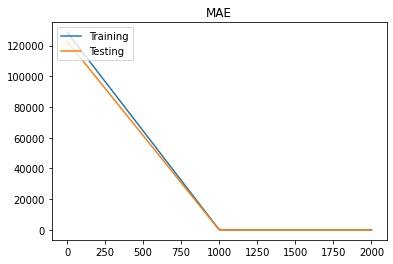

In [101]:
fig1 = plt.figure(1)
x=np.linspace(1,epo,epo)
plt.plot(x,train_error, label = 'Training')
plt.plot(x,test_error, label ='Testing')
plt.legend(loc = 2)
plt.title('MAE')

plt.show()

In [102]:
print(np.min(test_error))

7.093498443585324


# Y = b0 + b1X1 + b2X2

In [67]:
x1=np.zeros([243,1704])
x2=np.zeros([243,6816])

#x1 (0th~1703th column as x)
for i in range (0,243):
    for j in range (0,71):
        a=np.array(data['obs_PMf'][6816*i+96*j:6816*i+96*j+24])
        for k in range (0,24):
            if a[k]=='\\N' :
                a[k]=np.nan
        for k in range (0,24):
            x1[i][j*24+k]=a[k]

#x2 (1704th~8519th column as x)
for i in range (1,244):
    b=np.array(data['cal_PMf'][6816*i:6816*i+6816])
    for j in range(0,6816):
        if b[j]=='\\N' :
            b[j]=np.nan
    for j in range(0,6816):
        x2[i-1][j]=b[j]
        
print(np.shape(x1))
print(np.shape(x2))

(243, 1704)
(243, 6816)


In [68]:
x1Restruct=sinkr.dineof(x1)
x2Restruct=sinkr.dineof(x2)

[1] "1 EOF ; RMS = 7.34673151"
[1] "1 EOF ; RMS = 7.31158122"
[1] "1 EOF ; RMS = 7.31372817"
[1] "2 EOF ; RMS = 6.59118508"
[1] "2 EOF ; RMS = 6.59653877"
[1] "3 EOF ; RMS = 6.13828726"
[1] "3 EOF ; RMS = 6.13567946"
[1] "3 EOF ; RMS = 6.13517573"
[1] "3 EOF ; RMS = 6.13494526"
[1] "3 EOF ; RMS = 6.13485496"
[1] "3 EOF ; RMS = 6.13482155"
[1] "3 EOF ; RMS = 6.13480941"
[1] "3 EOF ; RMS = 6.13480502"
[1] "4 EOF ; RMS = 5.80494096"
[1] "4 EOF ; RMS = 5.80329288"
[1] "4 EOF ; RMS = 5.80325796"
[1] "4 EOF ; RMS = 5.80320468"
[1] "4 EOF ; RMS = 5.80318234"
[1] "4 EOF ; RMS = 5.80317507"
[1] "5 EOF ; RMS = 5.57098871"
[1] "5 EOF ; RMS = 5.57602323"
[1] "6 EOF ; RMS = 5.44638947"
[1] "6 EOF ; RMS = 5.45025482"
[1] "7 EOF ; RMS = 5.36847431"
[1] "7 EOF ; RMS = 5.37645583"
[1] "8 EOF ; RMS = 5.31041536"
[1] "8 EOF ; RMS = 5.31257344"
[1] "9 EOF ; RMS = 5.20167017"
[1] "9 EOF ; RMS = 5.20167237"
[1] "10 EOF ; RMS = 5.13164224"
[1] "10 EOF ; RMS = 5.13971001"
[1] "11 EOF ; RMS = 5.10997602"
[1] "

In [69]:
x1Restruct_Fun=np.array(x1Restruct[0])
x2Restruct_Fun=np.array(x2Restruct[0])
print(np.shape(x1Restruct_Fun))
print(np.shape(x2Restruct_Fun))

(243, 1704)
(243, 6816)


In [70]:
YRestruct_Fun=np.zeros([239,6816])
for i in range (0,239):
    for j in range (0,1704):
        YRestruct_Fun[i][j]=x1Restruct_Fun[i+1][j]
    for j in range (1704,3408):
        YRestruct_Fun[i][j]=x1Restruct_Fun[i+2][j-1704]
    for j in range (3408,5112):
        YRestruct_Fun[i][j]=x1Restruct_Fun[i+3][j-3408]
    for j in range (5112,6816):
        YRestruct_Fun[i][j]=x1Restruct_Fun[i+4][j-5112]
print(np.shape(YRestruct_Fun))

(239, 6816)


In [71]:
XRestruct_Fun=np.zeros([239,8520])
for i in range (0,239):
    for j in range (0,1704):
        XRestruct_Fun[i][j]=x1Restruct_Fun[i][j]
    for j in range (1704,8520):
        XRestruct_Fun[i][j]=x2Restruct_Fun[i][j-1704]
print(np.shape(XRestruct_Fun))

(239, 8520)


In [72]:
Xhat=XRestruct_Fun
Yhat=YRestruct_Fun
X1hat_train = np.zeros([239,1704])
X2hat_train = np.zeros([239,6816])
Yhat_train = np.zeros([239,6816])
for i in range (0,239):
    for j in range (0,1704):
        X1hat_train[i][j] = Xhat[i][j]
    for j in range (0,6816):
        X2hat_train[i][j] = Xhat[i][j+1704]
    for j in range (0,6816):    
        Yhat_train[i][j] = Yhat[i][j]

X1hat_test = np.zeros([30,1704])
X2hat_test = np.zeros([30,6816])
Yhat_test = np.zeros([30,6816])
x=np.zeros([273,8520])
y=np.zeros([273,6816])
#x1 (0th~1703th column as x)
for i in range (0,273):
    for j in range (0,71):
        a=np.array(data['obs_PMf'][6816*i+96*j:6816*i+96*j+24])
        for k in range (0,24):
            if a[k]=='\\N' :
                a[k]=np.nan
        for k in range (0,24):
            x[i][j*24+k]=a[k]

#x2 (1704th~8519th column as x)
for i in range (1,274):
    b=np.array(data['cal_PMf'][6816*i:6816*i+6816])
    for j in range(0,6816):
        if b[j]=='\\N' :
            b[j]=np.nan
    for j in range(0,6816):
        x[i-1][j+1704]=b[j]

#data_obs
for i in range (1,274):
    a=np.array(data['obs_PMf'][6816*i:6816*i+6816])
    for j in range(0,6816):
        if a[j]=='\\N' :
            a[j]=np.nan
    y[i-1]=a
xRestruct=sinkr.dineof(x)
yRestruct=sinkr.dineof(y)
xRestruct_Fun=np.array(xRestruct[0])
yRestruct_Fun=np.array(yRestruct[0])
    
for i in range (243,273):
    for j in range (0,1704):
        X1hat_test[i-243][j]=xRestruct_Fun[i][j] 
    for j in range (0,6816):
        X2hat_test[i-243][j]=xRestruct_Fun[i][j+1704]
    for j in range(0,6816):
        Yhat_test[i-243][j]=yRestruct_Fun[i][j]

[1] "1 EOF ; RMS = 9.381921"
[1] "1 EOF ; RMS = 9.37341075"
[1] "1 EOF ; RMS = 9.37276874"
[1] "1 EOF ; RMS = 9.37265741"
[1] "1 EOF ; RMS = 9.37264002"
[1] "1 EOF ; RMS = 9.37263815"
[1] "2 EOF ; RMS = 8.64084804"
[1] "2 EOF ; RMS = 8.64152905"
[1] "3 EOF ; RMS = 8.40491472"
[1] "3 EOF ; RMS = 8.40853219"
[1] "4 EOF ; RMS = 8.20012375"
[1] "4 EOF ; RMS = 8.20526189"
[1] "5 EOF ; RMS = 7.97867164"
[1] "5 EOF ; RMS = 7.97752159"
[1] "5 EOF ; RMS = 7.97836036"
[1] "6 EOF ; RMS = 7.84713084"
[1] "6 EOF ; RMS = 7.85248259"
[1] "7 EOF ; RMS = 7.74196413"
[1] "7 EOF ; RMS = 7.74615625"
[1] "8 EOF ; RMS = 7.69004836"
[1] "8 EOF ; RMS = 7.70033472"
[1] "9 EOF ; RMS = 7.60995442"
[1] "9 EOF ; RMS = 7.61537988"
[1] "10 EOF ; RMS = 7.54608767"
[1] "10 EOF ; RMS = 7.5591831"
[1] "11 EOF ; RMS = 7.52163475"
[1] "11 EOF ; RMS = 7.53280447"
[1] "12 EOF ; RMS = 7.51762144"
[1] "12 EOF ; RMS = 7.53850916"
[1] "13 EOF ; RMS = 7.51406299"
[1] "13 EOF ; RMS = 7.52827808"
[1] "14 EOF ; RMS = 7.50425817"
[1

In [73]:
print('X1hat_train')
#print(X1hat_train)
print(np.shape(X1hat_train))
print('X2hat_train')
#print(X2hat_train)
print(np.shape(X2hat_train))
print('Yhat_train')
#print(Yhat_train)
print(np.shape(Yhat_train))
print('X1hat_test')
#print(X1hat_test)
print(np.shape(X1hat_test))
print('X2hat_test')
#print(X2hat_test)
print(np.shape(X2hat_test))
print('Yhat_test')
#print(Yhat_test)
print(np.shape(Yhat_test))

X1hat_train
(239, 1704)
X2hat_train
(239, 6816)
Yhat_train
(239, 6816)
X1hat_test
(30, 1704)
X2hat_test
(30, 6816)
Yhat_test
(30, 6816)


## GD

In [74]:
x1 = X1hat_train
x2 = X2hat_train
y = Yhat_train
xt1 = X1hat_test
xt2 = X2hat_test
yt = Yhat_test

In [75]:
def model (x1,x2,b0,b1,b2):
    y = b0 +  torch.matmul(x1,b1) + torch.matmul(x2,b2)
    return y

# def model (x1,x2,b0,b1,b2):
#     # y = b0 +  torch.matmul(x1,b1) + torch.matmul(x2,b2)
#     # y = torch.add(b0 +  torch.matmul(x,b1))
#     # y = b0 +  torch.mm(x,b1)

#     b = torch.mean(b1*x1)*torch.ones(6816)
#     y = b0 + b+ b2*x2
#     return y

In [77]:
features1 = torch.from_numpy(x1)
features2 = torch.from_numpy(x2)
targets = torch.from_numpy(y)
x_test1 = torch.from_numpy(xt1)
x_test2 = torch.from_numpy(xt2)
y_test = torch.from_numpy(yt)

# beta0 = torch.randn(6816 , requires_grad = True)
# beta1 = torch.randn([1704,6816] , requires_grad = True)
# beta2 = torch.randn([6816,6816] , requires_grad = True)

beta0 = torch.ones(6816 , requires_grad = True)
beta1 = torch.ones([1704,6816], requires_grad = True)
beta2 = torch.ones([6816,6816], requires_grad = True)

rate = 1e-3
optimizer = optim.Adam([beta0 , beta1 , beta2], lr=rate)

epo = 2001
loss = nn.L1Loss()
train_error = np.zeros(epo)
test_error = np.zeros(epo)


for epoch in range (epo):
    yhats_train = model(features1.float() , features2.float(), beta0 , beta1 , beta2)
    train_loss = loss(targets.float() , yhats_train)
    train_error[epoch] = train_loss

    optimizer.zero_grad()
    train_loss.backward() 
    optimizer.step()    

    yhats_test = model(x_test1.float(), x_test2.float() , beta0, beta1 , beta2) 
#     for i in range (25):
#         for j in range (6816):
#             if y_test[i][j] == 0:
#                 yhats_test[i][j] = 0
    r = torch.abs(yhats_test - y_test)
    test_loss = torch.mean(r)
    # test_loss = loss(y_test , yhats_test)
    test_error[epoch] = test_loss

    if epoch <= 10 or epoch % 10 == 0:
        print(f"Epoch {epoch}, Training loss {train_loss.item():.4f},"
                    f" Testing loss {test_loss.item():.4f}")
        # print('\tBeta_0 : ' , beta0)
        # print('\tBeta_1 : ' , beta1)
        # print('\tBeta_2 : ' , beta2)       
    else :
        if epoch >= epo-10 :
            print(f"Epoch {epoch}, Training loss {train_loss.item():.4f},"
                        f" Testing loss {test_loss.item():.4f}")
            # print('\tBeta_0 : ' , beta0)
            # print('\tBeta_1 : ' , beta1)
            # print('\tBeta_2 : ' , beta2)       

Epoch 0, Training loss 128660.9609, Testing loss 122755.7783
Epoch 1, Training loss 128532.2891, Testing loss 122632.8885
Epoch 2, Training loss 128403.6172, Testing loss 122509.9984
Epoch 3, Training loss 128274.9453, Testing loss 122387.0997
Epoch 4, Training loss 128146.2578, Testing loss 122264.2033
Epoch 5, Training loss 128017.5781, Testing loss 122141.3182
Epoch 6, Training loss 127888.9141, Testing loss 122018.4362
Epoch 7, Training loss 127760.2578, Testing loss 121895.5299
Epoch 8, Training loss 127631.5625, Testing loss 121772.6429
Epoch 9, Training loss 127502.8828, Testing loss 121649.7437
Epoch 10, Training loss 127374.2109, Testing loss 121526.8552
Epoch 20, Training loss 126087.4844, Testing loss 120297.9705
Epoch 30, Training loss 124800.7422, Testing loss 119068.9911
Epoch 40, Training loss 123514.0000, Testing loss 117840.0836
Epoch 50, Training loss 122227.2422, Testing loss 116611.1533
Epoch 60, Training loss 120940.5078, Testing loss 115382.2349
Epoch 70, Training

Epoch 1280, Training loss 10.1795, Testing loss 11.6645
Epoch 1290, Training loss 10.2104, Testing loss 11.9745
Epoch 1300, Training loss 10.4840, Testing loss 11.9189
Epoch 1310, Training loss 10.5114, Testing loss 12.0834
Epoch 1320, Training loss 10.5964, Testing loss 12.0566
Epoch 1330, Training loss 10.8564, Testing loss 12.3310
Epoch 1340, Training loss 10.8494, Testing loss 12.2237
Epoch 1350, Training loss 10.8183, Testing loss 12.4001
Epoch 1360, Training loss 11.1322, Testing loss 12.3732
Epoch 1370, Training loss 11.2186, Testing loss 12.4941
Epoch 1380, Training loss 11.1912, Testing loss 12.5210
Epoch 1390, Training loss 11.3994, Testing loss 12.6880
Epoch 1400, Training loss 11.4348, Testing loss 12.5605
Epoch 1410, Training loss 11.3008, Testing loss 12.6244
Epoch 1420, Training loss 11.4946, Testing loss 12.6046
Epoch 1430, Training loss 11.4964, Testing loss 12.7479
Epoch 1440, Training loss 11.5360, Testing loss 12.7669
Epoch 1450, Training loss 11.7044, Testing loss 

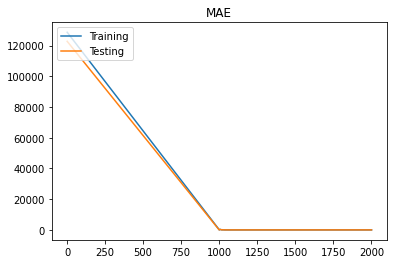

In [78]:
fig1 = plt.figure(1)
x=np.linspace(1,epo,epo)
plt.plot(x,train_error, label = 'Training')
plt.plot(x,test_error, label ='Testing')
plt.legend(loc = 2)
plt.title('MAE')

plt.show()

In [80]:
print(np.min(test_error))

7.089616358830082


# LBFGS

## Y = b0 + b1X1 (96hr) 

In [112]:
###
#cal_PMf  
###
u=np.zeros([244,6816])
for i in range (0,244):
    a=np.array(data['cal_PMf'][6816*i:6816*i+6816])
    for j in range(0,6816):
        if a[j]=='\\N' :
            a[j]=np.nan
    u[i]=a.T
###
#obs_PMf
###
v=np.zeros([244,6816])
for i in range (0,244):
    a=np.array(data['obs_PMf'][6816*i:6816*i+6816])
    for j in range(0,6816):
        if a[j]=='\\N' :
            a[j]=np.nan
    v[i]=a.T
    
XRestruct=sinkr.dineof(u)
YRestruct=sinkr.dineof(v)
XRestruct_Fun=np.array(XRestruct[0])
YRestruct_Fun=np.array(YRestruct[0])

Xhat=XRestruct_Fun
Yhat=YRestruct_Fun
Xhat_train = np.zeros([244,6816])
Yhat_train = np.zeros([244,6816])
for i in range (0,244):
    for j in range (0,6816):
        Xhat_train[i][j] = Xhat[i][j]
        Yhat_train[i][j] = Yhat[i][j]

Xhat_test = np.zeros([30,6816])
Yhat_test = np.zeros([30,6816])
#data_cal
for i in range (244,274):
    a=np.array(data['cal_PMf'][6816*i:6816*i+6816])
    for j in range(0,6816):
        if a[j]=='\\N' :
            a[j]=np.nan
    Xhat_test[i-244]=a
#data_obs
for i in range (244,274):
    a=np.array(data['obs_PMf'][6816*i:6816*i+6816])
    for j in range(0,6816):
        if a[j]=='\\N' :
            a[j]=np.nan
    Yhat_test[i-244]=a

[1] "1 EOF ; RMS = 10.27211422"
[1] "1 EOF ; RMS = 10.26501442"
[1] "1 EOF ; RMS = 10.26492936"
[1] "1 EOF ; RMS = 10.26497963"
[1] "2 EOF ; RMS = 9.45481862"
[1] "2 EOF ; RMS = 9.45536768"
[1] "3 EOF ; RMS = 9.11077811"
[1] "3 EOF ; RMS = 9.11367005"
[1] "4 EOF ; RMS = 8.88785888"
[1] "4 EOF ; RMS = 8.89446532"
[1] "5 EOF ; RMS = 8.73260332"
[1] "5 EOF ; RMS = 8.75194643"
[1] "6 EOF ; RMS = 8.60766547"
[1] "6 EOF ; RMS = 8.61449742"
[1] "7 EOF ; RMS = 8.55258166"
[1] "7 EOF ; RMS = 8.56998542"
[1] "8 EOF ; RMS = 8.4745616"
[1] "8 EOF ; RMS = 8.48084076"
[1] "9 EOF ; RMS = 8.40640192"
[1] "9 EOF ; RMS = 8.42013927"
[1] "10 EOF ; RMS = 8.40354041"
[1] "10 EOF ; RMS = 8.43096272"
[1] "11 EOF ; RMS = 8.39670075"
[1] "11 EOF ; RMS = 8.42219993"
[1] "12 EOF ; RMS = 8.39549966"
[1] "12 EOF ; RMS = 8.42182266"
[1] "13 EOF ; RMS = 8.36028745"
[1] "13 EOF ; RMS = 8.37477931"
[1] "14 EOF ; RMS = 8.38182397"
[1] "1 EOF ; RMS = 8.08186998"
[1] "1 EOF ; RMS = 8.037959"
[1] "1 EOF ; RMS = 8.03683876

In [113]:
x = Xhat_train
y = Yhat_train
xt = Xhat_test
yt = Yhat_test

In [114]:
def model (x,b0,b1):
    # y = b0 +  torch.matmul(x,b1)
    y = b0 + b1*x
    return y

In [117]:
features = torch.from_numpy(x)
targets = torch.from_numpy(y)
x_test = torch.from_numpy(xt)
y_test = torch.from_numpy(yt)

beta0 = torch.ones(6816 , requires_grad = True)
# beta0 = torch.randn([244,6816] , requires_grad = True)
beta1 = torch.ones(6816 , requires_grad = True)

rate = 1e-2
optimizer = optim.LBFGS([beta0 , beta1] , lr = rate)

epo = 201
loss = nn.MSELoss()
train_error = np.zeros(epo)
test_error = np.zeros(epo)


for epoch in range (epo):
    # yhats_train = model(features.float() , beta0 , beta1)
    # train_loss = loss(targets.float() , yhats_train)
    # train_error[epoch] = train_loss

    # optimizer.zero_grad()
    # if epoch == 0 :
    #         train_loss.backward(retain_graph=True) 
    # else :
    #     train_loss.backward()
    # # train_loss.backward() 
    # optimizer.step()    

    def closure():
        yhats_train = model(features.float() , beta0 , beta1)
        train_loss = loss(targets.float() , yhats_train)
        train_error[epoch] = train_loss
        optimizer.zero_grad()
        # if epoch == 0 :
        #     train_loss.backward(retain_graph=True) 
        # else :
        #     train_loss.backward()
        train_loss.backward(retain_graph=True) 
        return train_loss
    optimizer.step(closure)    

    yhats_test = model(x_test.float(), beta0, beta1) 
#     for i in range (30):
#         for j in range (6816):
#             if y_test[i][j] == 0:
#                 yhats_test[i][j] = 0
    r = torch.abs(yhats_test - y_test)
    test_loss = torch.nanmean(r)
    test_error[epoch] = test_loss

    if epoch <= 10 or epoch % 10 == 0:
        print(f"Epoch {epoch}, Training loss {train_error[epoch]:.4f},"
                    f" Testing loss {test_error[epoch]:.4f}")
        # print(f"Epoch {epoch}, Training loss {train_loss.item():.4f},"
        #             f" Testing loss {test_loss:.4f}")
        # print('\tBeta_0 : ' , beta0.grad)
        # print('\tBeta_1 : ' , beta1.grad)
    else :
        if epoch >= epo-10 :
            print(f"Epoch {epoch}, Training loss {train_error[epoch]:.4f},"
                    f" Testing loss {test_error[epoch]:.4f}")
            # print(f"Epoch {epoch}, Training loss {train_loss.item():.4f},"
            #             f" Testing loss {test_loss:.4f}")
            # print('\tBeta_0 : ' , beta0)
            # print('\tBeta_1 : ' , beta1)

Epoch 0, Training loss 144.8100, Testing loss 7.2946
Epoch 1, Training loss 132.1356, Testing loss 7.1739
Epoch 2, Training loss 123.6289, Testing loss 7.1072
Epoch 3, Training loss 117.7867, Testing loss 7.0728
Epoch 4, Training loss 113.6954, Testing loss 7.0577
Epoch 5, Training loss 110.7545, Testing loss 7.0538
Epoch 6, Training loss 108.5668, Testing loss 7.0549
Epoch 7, Training loss 106.8258, Testing loss 7.0555
Epoch 8, Training loss 105.1671, Testing loss 7.0472
Epoch 9, Training loss 103.1031, Testing loss 7.0117
Epoch 10, Training loss 100.0359, Testing loss 6.9113
Epoch 20, Training loss 83.8789, Testing loss 6.0090
Epoch 30, Training loss 83.1840, Testing loss 5.9521
Epoch 40, Training loss 83.1389, Testing loss 5.9490
Epoch 50, Training loss 83.1365, Testing loss 5.9494
Epoch 60, Training loss 83.1363, Testing loss 5.9495
Epoch 70, Training loss 83.1362, Testing loss 5.9496
Epoch 80, Training loss 83.1362, Testing loss 5.9496
Epoch 90, Training loss 83.1361, Testing loss

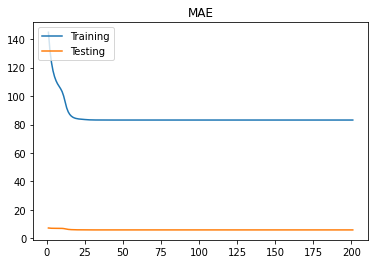

In [120]:
fig1 = plt.figure(1)
x=np.linspace(1,epo,epo)
plt.plot(x,train_error, label = 'Training')
plt.plot(x,test_error, label ='Testing')
plt.legend(loc = 2)
plt.title('MAE')

plt.show()

In [119]:
print(np.min(test_error))

5.948969441248646


## Y = b0 + b1X12 (120hr)

In [4]:
x1=np.zeros([243,1704])
x2=np.zeros([243,6816])

#x1 (0th~1703th column as x)
for i in range (0,243):
    for j in range (0,71):
        a=np.array(data['obs_PMf'][6816*i+96*j:6816*i+96*j+24])
        for k in range (0,24):
            if a[k]=='\\N' :
                a[k]=np.nan
        for k in range (0,24):
            x1[i][j*24+k]=a[k]

#x2 (1704th~8519th column as x)
for i in range (1,244):
    b=np.array(data['cal_PMf'][6816*i:6816*i+6816])
    for j in range(0,6816):
        if b[j]=='\\N' :
            b[j]=np.nan
    for j in range(0,6816):
        x2[i-1][j]=b[j]
        
x1Restruct=sinkr.dineof(x1)
x2Restruct=sinkr.dineof(x2)
x1Restruct_Fun=np.array(x1Restruct[0])
x2Restruct_Fun=np.array(x2Restruct[0])

YRestruct_Fun=np.zeros([239,6816])
for i in range (0,239):
    for j in range (0,1704):
        YRestruct_Fun[i][j]=x1Restruct_Fun[i+1][j]
    for j in range (1704,3408):
        YRestruct_Fun[i][j]=x1Restruct_Fun[i+2][j-1704]
    for j in range (3408,5112):
        YRestruct_Fun[i][j]=x1Restruct_Fun[i+3][j-3408]
    for j in range (5112,6816):
        YRestruct_Fun[i][j]=x1Restruct_Fun[i+4][j-5112]
        
XRestruct_Fun=np.zeros([239,8520])
for i in range (0,239):
    for j in range (0,1704):
        XRestruct_Fun[i][j]=x1Restruct_Fun[i][j]
    for j in range (1704,8520):
        XRestruct_Fun[i][j]=x2Restruct_Fun[i][j-1704]
        
Xhat=XRestruct_Fun
Yhat=YRestruct_Fun
Xhat_train = np.zeros([239,8520])
Yhat_train = np.zeros([239,6816])
for i in range (0,239):
    for j in range (0,8520):
        Xhat_train[i][j] = Xhat[i][j]
    for j in range (0,6816):    
        Yhat_train[i][j] = Yhat[i][j]

Xhat_test = np.zeros([30,8520])
Yhat_test = np.zeros([30,6816])
x=np.zeros([273,8520])
y=np.zeros([273,6816])
#x1 (0th~1703th column as x)
for i in range (0,273):
    for j in range (0,71):
        a=np.array(data['obs_PMf'][6816*i+96*j:6816*i+96*j+24])
        for k in range (0,24):
            if a[k]=='\\N' :
                a[k]=np.nan
        for k in range (0,24):
            x[i][j*24+k]=a[k]

#x2 (1704th~8519th column as x)
for i in range (1,274):
    b=np.array(data['cal_PMf'][6816*i:6816*i+6816])
    for j in range(0,6816):
        if b[j]=='\\N' :
            b[j]=np.nan
    for j in range(0,6816):
        x[i-1][j+1704]=b[j]

#data_obs
for i in range (1,274):
    a=np.array(data['obs_PMf'][6816*i:6816*i+6816])
    for j in range(0,6816):
        if a[j]=='\\N' :
            a[j]=np.nan
    y[i-1]=a
xRestruct=sinkr.dineof(x)
yRestruct=sinkr.dineof(y)
xRestruct_Fun=np.array(xRestruct[0])
yRestruct_Fun=np.array(yRestruct[0])
    
for i in range (243,273):
    for j in range (0,8520):
        Xhat_test[i-243][j]=xRestruct_Fun[i][j]
    for j in range(0,6816):
        Yhat_test[i-243][j]=yRestruct_Fun[i][j]
    

[1] "1 EOF ; RMS = 7.59471921"
[1] "1 EOF ; RMS = 7.55029624"
[1] "1 EOF ; RMS = 7.54926743"
[1] "1 EOF ; RMS = 7.54914693"
[1] "1 EOF ; RMS = 7.54912286"
[1] "1 EOF ; RMS = 7.54911756"
[1] "2 EOF ; RMS = 6.65979528"
[1] "2 EOF ; RMS = 6.65246361"
[1] "2 EOF ; RMS = 6.65174798"
[1] "2 EOF ; RMS = 6.65160043"
[1] "2 EOF ; RMS = 6.65156239"
[1] "2 EOF ; RMS = 6.651552"
[1] "2 EOF ; RMS = 6.65154913"
[1] "3 EOF ; RMS = 6.21193435"
[1] "3 EOF ; RMS = 6.21394993"
[1] "4 EOF ; RMS = 5.88874064"
[1] "4 EOF ; RMS = 5.9006884"
[1] "5 EOF ; RMS = 5.6404382"
[1] "5 EOF ; RMS = 5.64009827"
[1] "5 EOF ; RMS = 5.64048726"
[1] "6 EOF ; RMS = 5.50322584"
[1] "6 EOF ; RMS = 5.50282326"
[1] "6 EOF ; RMS = 5.50264793"
[1] "6 EOF ; RMS = 5.5025459"
[1] "6 EOF ; RMS = 5.50250614"
[1] "6 EOF ; RMS = 5.50249248"
[1] "6 EOF ; RMS = 5.50248806"
[1] "7 EOF ; RMS = 5.4359113"
[1] "7 EOF ; RMS = 5.44968466"
[1] "8 EOF ; RMS = 5.38396247"
[1] "8 EOF ; RMS = 5.39245792"
[1] "9 EOF ; RMS = 5.35671467"
[1] "9 EOF ; R

In [5]:
x = Xhat_train
y = Yhat_train
xt = Xhat_test
yt = Yhat_test

In [6]:
def model (x,b0,b1):
    y = b0 +  torch.mm(x , b1)
    return y

In [ ]:
features = torch.from_numpy(x)
targets = torch.from_numpy(y)
x_test = torch.from_numpy(xt)
y_test = torch.from_numpy(yt)

beta0 = torch.ones(6816 , requires_grad = True)
beta1 = torch.ones([8520,6816] , requires_grad = True)

rate = 1e-2
optimizer = optim.LBFGS([beta0 , beta1] , lr = rate)

epo = 201
loss = nn.MSELoss()
train_error = np.zeros(epo)
test_error = np.zeros(epo)


for epoch in range (epo):
    # yhats_train = model(features.float() , beta0 , beta1)
    # train_loss = loss(targets.float() , yhats_train)
    # train_error[epoch] = train_loss

    # optimizer.zero_grad()
    # if epoch == 0 :
    #         train_loss.backward(retain_graph=True) 
    # else :
    #     train_loss.backward()
    # # train_loss.backward() 
    # optimizer.step()    

    def closure():
        yhats_train = model(features.float() , beta0 , beta1)
        train_loss = loss(targets.float() , yhats_train)
        train_error[epoch] = train_loss
        optimizer.zero_grad()
        # if epoch == 0 :
        #     train_loss.backward(retain_graph=True) 
        # else :
        #     train_loss.backward()
        train_loss.backward(retain_graph=True) 
        return train_loss
    optimizer.step(closure)    

    yhats_test = model(x_test.float(), beta0, beta1) 
#     for i in range (25):
#         for j in range (6816):
#             if y_test[i][j] == 0:
#                 yhats_test[i][j] = 0
    r = torch.abs(yhats_test - y_test)
    test_loss = torch.nanmean(r)
    test_error[epoch] = test_loss

    if epoch <= 10 or epoch % 10 == 0:
        print(f"Epoch {epoch}, Training loss {train_error[epoch]:.4f},"
                    f" Testing loss {test_error[epoch]:.4f}")
        # print(f"Epoch {epoch}, Training loss {train_loss.item():.4f},"
        #             f" Testing loss {test_loss:.4f}")
        # print('\tBeta_0 : ' , beta0.grad)
        # print('\tBeta_1 : ' , beta1.grad)
    else :
        if epoch >= epo-10 :
            print(f"Epoch {epoch}, Training loss {train_error[epoch]:.4f},"
                        f" Testing loss {test_error[epoch]:.4f}")
            # print(f"Epoch {epoch}, Training loss {train_loss.item():.4f},"
            #             f" Testing loss {test_loss:.4f}")
            # print('\tBeta_0 : ' , beta0)
            # print('\tBeta_1 : ' , beta1)

Epoch 0, Training loss 21391738880.0000, Testing loss 122887.4376
Epoch 1, Training loss 715327012864.0000, Testing loss 697812.4868
Epoch 2, Training loss 478533451776.0000, Testing loss 570589.2935


In [ ]:
fig1 = plt.figure(1)
x=np.linspace(1,epo,epo)
plt.plot(x,train_error, label = 'Training')
plt.plot(x,test_error, label ='Testing')
plt.legend(loc = 2)
plt.title('MAE')

plt.show()

In [ ]:
print(np.min(test_error))

## Y = b0 + b1X1 + b2X2 (24+96hr)

In [ ]:
features1 = torch.from_numpy(x1)
features2 = torch.from_numpy(x2)
targets = torch.from_numpy(y)
x_test1 = torch.from_numpy(xt1)
x_test2 = torch.from_numpy(xt2)
y_test = torch.from_numpy(yt)

beta0 = torch.ones(6816 , requires_grad = True)
beta1 = torch.ones([1704,6816], requires_grad = True)
beta2 = torch.ones([6816,6816] , requires_grad = True)

# rate = 1
rate = 1e-2
optimizer = optim.LBFGS([beta0 , beta1 , beta2] , lr=rate)
# optimizer = optim.Adam([beta0 , beta1 , beta2], lr=rate)
# optimizer = optim.SGD([beta0 , beta1 , beta2], lr=rate)

epo = 201
loss = nn.MSELoss()
train_error = np.zeros(epo)
test_error = np.zeros(epo)

for epoch in range (epo):
    # yhats_train = model(features.float() , beta0 , beta1)
    # train_loss = loss(targets.float() , yhats_train)
    # train_error[epoch] = train_loss

    # optimizer.zero_grad()
    # if epoch == 0 :
    #         train_loss.backward(retain_graph=True) 
    # else :
    #     train_loss.backward()
    # # train_loss.backward() 
    # optimizer.step()    

    def closure():
        yhats_train = model(features1.float() , features2.float(), beta0 , beta1 , beta2)
        train_loss = loss(targets.float() , yhats_train)
        train_error[epoch] = train_loss
        optimizer.zero_grad()
        # if epoch == epo-1 :
        #     train_loss.backward() 
        # else :
        #     train_loss.backward(retain_graph=True)
        train_loss.backward(retain_graph=True)
        return train_loss
    optimizer.step(closure)    

    yhats_test = model(x_test1.float(), x_test2.float() , beta0, beta1 , beta2) 
#     for i in range (25):
#         for j in range (6816):
#             if y_test[i][j] == 0:
#                 yhats_test[i][j] = 0
    r = torch.abs(yhats_test - y_test)
    test_loss = torch.mean(r)
    test_error[epoch] = test_loss

    if epoch <= 10 or epoch % 10 == 0:
        print(f"Epoch {epoch}, Training loss {train_error[epoch]:.4f},"
                    f" Testing loss {test_error[epoch]:.4f}")
        # print(f"Epoch {epoch}, Training loss {train_loss.item():.4f},"
        #             f" Testing loss {test_loss.item():.4f}")

        # print('\tBeta_0 : ' , beta0)
        # print('\tBeta_1 : ' , beta1)
        # print('\tBeta_2 : ' , beta2)       
    else :
        if epoch >= epo-10 :
            print(f"Epoch {epoch}, Training loss {train_error[epoch]:.4f},"
                        f" Testing loss {test_error[epoch]:.4f}")
            # print(f"Epoch {epoch}, Training loss {train_loss.item():.4f},"
            #             f" Testing loss {test_loss.item():.4f}")
            # print('\tBeta_0 : ' , beta0)
            # print('\tBeta_1 : ' , beta1)
            # print('\tBeta_2 : ' , beta2) 

In [ ]:
fig1 = plt.figure(1)
x=np.linspace(1,epo,epo)
plt.plot(x,train_error, label = 'Training')
plt.plot(x,test_error, label ='Testing')
plt.legend(loc = 2)
plt.title('MAE')

plt.show()

In [ ]:
print(np.min(test_error))